# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import numpy as np
from collections import defaultdict

# Helper Functions

In [2]:
def get_stats(path: str) -> tuple:
    df_plain: pd.DataFrame = pd.read_csv(path, index_col=0)
    n: int = int(df_plain.iloc[len(df_plain) - 1].values[0][3::])
    df = df_plain.loc[range(0, len(df_plain) - 1)]
    total_neg: int = len(df)
    proportion: float = total_neg / n
    return n, total_neg, proportion

In [3]:
def get_stats_list(parent_path: str) -> list:
    stats: list = []
    for file in os.listdir(parent_path):
        if file.endswith(".csv"):
            stat: tuple = get_stats(os.path.join(parent_path, file))
            stats.append((file, stat))
    return stats

In [4]:
def get_total_stats(corpus_dict: dict, key: str) -> tuple:
    n: int = sum(map( lambda e: e[0], corpus_dict[key]), 0)
    p: int = sum(map( lambda e: e[1], corpus_dict[key]), 0)
    return n, p

In [5]:
def get_stats_dict(stats: list) -> dict:
    dict_tmp: dict = defaultdict(list)
    keys: list = ['wiki', 'bc', 'cc_news', 'owt']
    for stat in stats:
        for  key in keys:
            if bool(re.search(key, stat[0])):
                dict_tmp[key].append(stat[1])
                break
    ret_dict: dict = defaultdict(list)
    for key in keys:
        n, p = get_total_stats(dict_tmp, key)
        ret_dict[key].append((p, n))
    total_tuple: tuple = (
        sum(map( lambda e: ret_dict[e][0][0], ret_dict.keys()), 0),
        sum(map( lambda e: ret_dict[e][0][1], ret_dict.keys()), 0)
    )
    ret_dict['total'].append(total_tuple)
    return ret_dict

# Main

In [6]:
info_dict: dict = get_stats_dict(get_stats_list('../data/interim/csv/'))

/tmp/ipykernel_52526/937596319.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_plain: pd.DataFrame = pd.read_csv(path, index_col=0)
/tmp/ipykernel_52526/937596319.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_plain: pd.DataFrame = pd.read_csv(path, index_col=0)
/tmp/ipykernel_52526/937596319.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_plain: pd.DataFrame = pd.read_csv(path, index_col=0)
/tmp/ipykernel_52526/937596319.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_plain: pd.DataFrame = pd.read_csv(path, index_col=0)
/tmp/ipykernel_52526/937596319.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_plain: pd.DataFrame = pd.read_csv(path, index_col=0)
/tmp/ipykernel_52526/9375

In [7]:
info_dict

defaultdict(list,
            {'wiki': [(1874856, 34475502)],
             'bc': [(1252382, 7400422)],
             'cc_news': [(159487, 1335887)],
             'owt': [(5077694, 32605932)],
             'total': [(8364419, 75817743)]})

# Plotting

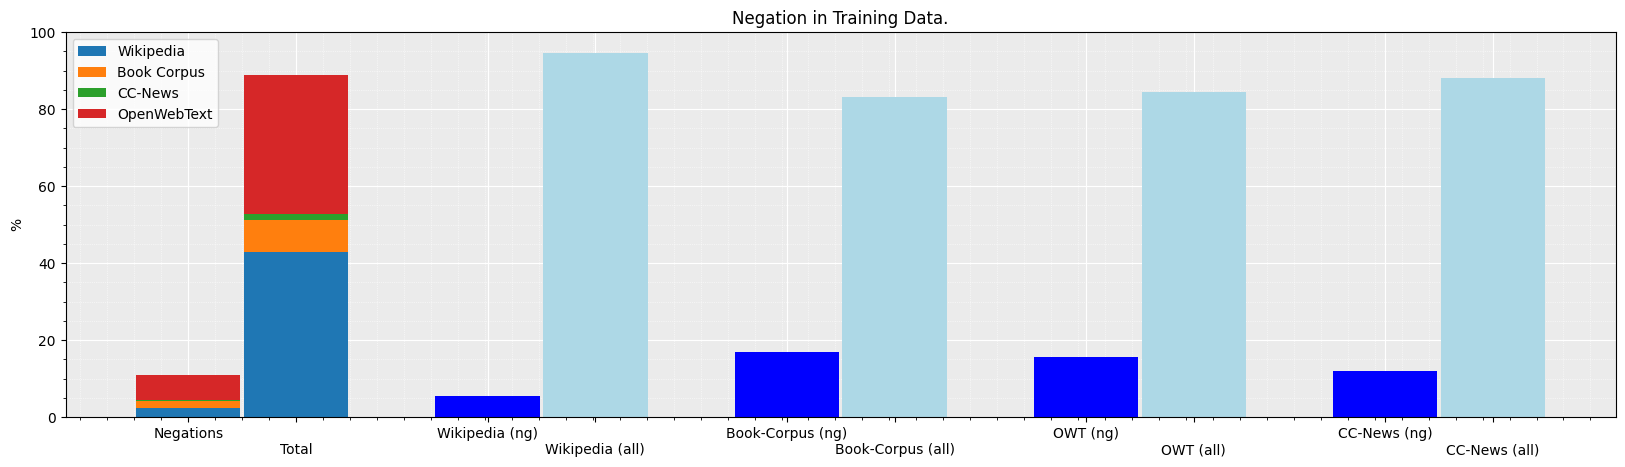

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def get_value_tuple(pos: int, elem: float, n: int) -> tuple:
    return tuple([0] * pos + [elem] + [0] * (n - pos - 1))

def get_sequence(width: float, n: int, offset_inter: float, offset_intra: float):
    rep_lst = lambda n: np.array(sum(list(map(lambda e: [e * (2 * width + offset_intra + offset_inter)] * 2, range(n))), []))
    return np.array([0, width + offset_intra] * n) + rep_lst(n)

def add_plot(x: list, val: float, ind: int, width: float, bottom: list, color: str = "blue"):
    val_tuple: tuple = get_value_tuple(ind, val, len(x))
    ax.bar(x, val_tuple, width, bottom=bottom, color=color)

# data from https://allisonhorst.github.io/palmerpenguins/

labels = (
    "Negations",
    "\nTotal",
    "Wikipedia (ng)",
    "\nWikipedia (all)",
    "Book-Corpus (ng)",
    "\nBook-Corpus (all)",
    "OWT (ng)",
    "\nOWT (all)",
    "CC-News (ng)",
    "\nCC-News (all)"
)
assert len(labels) % 2 == 0

width = 6
fig, ax = plt.subplots()
ax.set_facecolor('#EBEBEB')
ax.grid(which='major', color='white', linewidth=0.8)
ax.grid(which='minor', color='white', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_axisbelow(True)
bottom = np.zeros(len(labels))
x: list = get_sequence(width, int(len(labels) / 2), offset_inter=5, offset_intra=0.2)

counts: dict = info_dict.copy()
n: int = counts['total'][0][1]
del counts['total']

# Stacked Plot
label_dict: dict = {
    'owt' : "OpenWebText",
    'wiki': "Wikipedia",
    'bc': "Book Corpus",
    'cc_news': "CC-News"
}
for boolean, val in counts.items():
    weight_count = val[0]
    weight_count = tuple([weight_count[0] / n * 100, (weight_count[1] - weight_count[0]) / n * 100] +  [0] * (len(labels) - 2))
    p = ax.bar(x, weight_count, width, label=label_dict[boolean], bottom=bottom)
    bottom += weight_count

get_ng = lambda key: info_dict[key][0][0] / info_dict[key][0][1] * 100
get_no_ng = lambda key: (info_dict[key][0][1] - info_dict[key][0][0]) / info_dict[key][0][1] * 100

# WARNING: Keep order correctly for indexing
for key, i in zip(['wiki', 'bc', 'owt', 'cc_news'], range(2, len(labels) + 2, 2)):
    add_plot(x, get_ng(key), i, width, bottom, color="blue")
    add_plot(x, get_no_ng(key), i + 1, width, bottom, color="lightblue")

ax.set_title("Negation in Training Data.")
ax.legend(loc="upper left")
ax.set_ylabel("%")
ax.set_ylim(0, 100)

# Overwrite numbers on x-axis
my_xticks = ['Negations','All Sentences','Wiki']
plt.xticks(x, list(labels))
plt.rcParams["figure.figsize"] = (30,5)
name_file: str = "DataAnalysis.jpg"
path_save: str = os.path.join('figures', name_file)
plt.savefig(path_save)
plt.show()